On génère les données

In [2]:
import numpy as np

N = 3
x_1 = np.random.multivariate_normal(mean=[0,0], cov=[[0.1,0],[0,0.1]], size=N)
x_2 = np.random.multivariate_normal(mean=[3,0], cov=[[0.3,-0.1],[-0.1,0.2]], size=N)
x_3 = np.random.multivariate_normal(mean=[0,3], cov=[[0.2,0],[0,0.2]], size=N)
N = 3*N
X = np.concatenate((x_1, x_2, x_3))

On les visualise

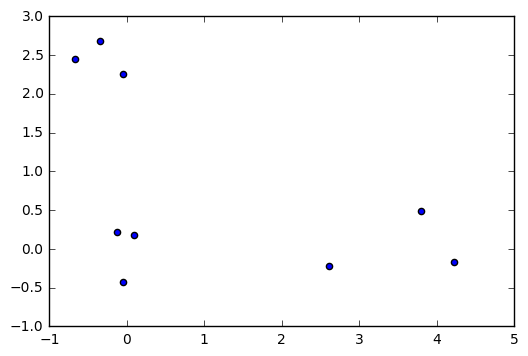

In [3]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1])
plt.show()

On les enregistre

In [4]:
import pandas
df = pandas.DataFrame(X)

In [6]:
df.to_csv("data.txt", sep="\t", header=None, index=False)

# Importation des données

In [7]:
dataText = sc.textFile("data.txt")

In [12]:
def process_row(row):
    values = row.split("\t")
    values = [float(_) for _ in values]
    return [values]

In [13]:
data = dataText.flatMap(process_row)
data.take(12)

[[-0.12062601549113369, 0.22305148205137285],
 [-0.04316140687603731, -0.42656358942141864],
 [0.09769570485396502, 0.18328614525838832],
 [4.221410905157858, -0.1639830581569055],
 [2.6031681941069076, -0.22515370643574856],
 [3.794130647258015, 0.4867018243342529],
 [-0.33967217452748155, 2.6847634907253917],
 [-0.04598493211471333, 2.263006239936773],
 [-0.6663365743715197, 2.4479258772449977]]

In [14]:
df

,0,1
0,-0.120626,0.223051
1,-0.043161,-0.426564
2,0.097696,0.183286
3,4.221411,-0.163983
4,2.603168,-0.225154
5,3.794131,0.486702
6,-0.339672,2.684763
7,-0.045985,2.263006
8,-0.666337,2.447926


C'est bon, les données ont bien étées importées

# Reducer A

Le reducer A à pour objectif d'aggréger les (potentiels) différents centroïdes d'un cluster.

In [ ]:
class ReducerA:
    """
    This class defines a reducer object that aggregates candidate centers when they are close enough given mappers in argument.
    """
    
    def __init__(self, mappers):
        """
        This is the class' constructor.
        """
        
        # List of the mapper objects
        self.__mappers = mappers
        
        # Number of mappers
        self.__N = mappers.shape[0]
        
        # Preference value
        self.__preference = [mappers[i].__S[0,0] for i in range(0, self.__N)]
        
        # Distance threshold to combine centers
        self.__threshold = [self.__preference[i] * 0.5 for i in range(0, self.__N)]
        
        # List of clusters
        self.__clusters = []
        
    def __distance(self, mapper_1, center_1, mapper_2, center_2):
        """
        This method computes the distance between two centers.
        
        Parameters
        ----------
        mapper_1 : Mapper object
                This is a mapper object.

        center_1 : integer
                This is the index i which represents the index of the center in mapper_1.
                
        mapper_2 : Mapper object
                This is a mapper object.

        center_2 : integer
                This is the index j which represents the index of the center in mapper_2.

        Returns
        -------
        d : float
                This is the euclidian distance between the center j from mapper i and center l from mapper k.
        """
        
        #Access the coordinate of the centers from the data
        x1 = mapper_1.__data[center_1]
        x2 = mapper_2.__data[center_2]
        
        # Compute euclidian distance
        d = np.linalg.norm(x2-x1)
        
        return d
        
    def __combine(self):
        """
        This method computes the average.
        
        Parameters
        ----------
        i : integer
                This is the index i needed to select the first point.

        k : integer
                This is the index k needed to select the first point.

        Returns
        -------
        a : float
                This is the availability of point i for k.
        """
        
        # Initialize the clusters to be : 1 center = 1 cluster
        self.__clusters = [(mapper, center) for mapper in range(self.__N) for center in range(self.__mapper[i].__centers)]
    
        # When we find two centers too close, aggregate them
        for i in range(self.__N): # For each mapper
            for j in range(self.__mappers[i].__centers.shape[0]): # For each center
                for k in range(self.__N): # For each mapper
                    for l in range(self.__mappers[k].__centers.shape[0]): # For each center
                        # Define properly mappers and centers
                        mapper_1 = self.__mappers[i]
                        center_1 = self.__mappers[i].__center[j]
                        mapper_2 = self.__mappers[k]
                        center_2 = self.__mappers[k].__center[l]
                        
                        tmp = self.__distance(mapper_1, center_1, mapper_2, center_2)
                        
                        if tmp < (mapper_1.__threshold + mapper_2.__threshold) / 2:
                            self.__clusters.append()
        
        # Autre essai..                     
        for i in range(self.__clusters.shape[0]):
            for j in range(self.__clusters.shape[0]):
                if i != j:
                    mapper_1 = self.__clusters[i][0]
                    center_1 = self.__clusters[i][1]
                    mapper_2 = self.__clusters[j][0]
                    center_2 = self.__clusters[j][1]
                    
                    tmp = self.__distance(mapper_1, center_1, mapper_2, center_2)
                    
                    if tmp < (mapper_1.__threshold + mapper_2.__threshold) / 2:
                            self.__clusters.append(())
                    
        return self.__clusters
  

In [15]:
def reducerB(row):
    centroides, individus = row
    nouveau_centroide = sc.parallelize(centroides).mean()
    return (nouveau_centroide, individus)